In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

import import_ipynb
from backdoor_attack_class import BackdoorAttack, PoisoningAttackCleanLabelBackdoor

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

importing Jupyter notebook from backdoor_attack_class.ipynb
importing Jupyter notebook from backdoor_attack_setup.ipynb
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def attack_dataset(dataset_clean, labels_clean, percent_poison, poison_func):
    dataset_attacked = np.copy(dataset_clean)
    labels_attacked = np.copy(labels_clean)
    is_poison = np.zeros(np.shape(labels_attacked))
    
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(labels_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = dataset_clean[labels_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = BackdoorAttack(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, attack_target_labels=np.ones(num_poison) * tgt)
        dataset_attacked = np.append(dataset_attacked, imgs_to_be_poisoned, axis=0)
        labels_attacked = np.append(labels_attacked, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, dataset_attacked, labels_attacked

In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = attack_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = attack_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
61/61 [==============================] - 10s 169ms/step - batch: 30.0000 - size: 128.0000 - loss: 0.7994 - acc: 0.7418
Epoch 2/3
61/61 [==============================] - 10s 160ms/step - batch: 30.0000 - size: 128.0000 - loss: 0.2466 - acc: 0.9279
Epoch 3/3
61/61 [==============================] - 11s 172ms/step - batch: 30.0000 - size: 128.0000 - loss: 0.1661 - acc: 0.95031s - batch: 26.0000 - size: 128.0000 - loss: 0.1682 - ac


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Clean test set accuracy: 96.58%


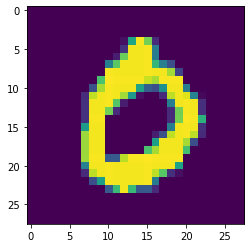

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

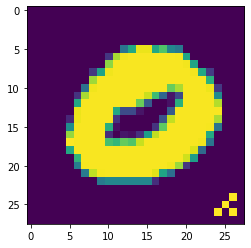

Prediction: 1

 Effectiveness of poison: 99.82%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 96.75%


In [11]:
#Extension

x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [12]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

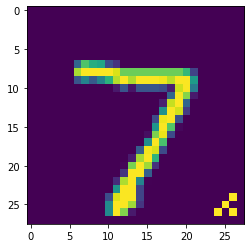

In [13]:
backdoor = BackdoorAttack(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

In [14]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0]

In [15]:
model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Adversarial training epochs: 100%|█████████████████████████████████████████████████████| 10/10 [13:17<00:00, 79.79s/it]


In [16]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Iterations:  96%|███████████████████████████████████████████████████████████▏  | 191/200 [00:07<00:00, 24.11it/s]


PGD - Iterations:  90%|███████████████████████████████████████████████████████▊      | 180/200 [00:07<00:00, 24.49it/s]


PGD - Iterations:  84%|████████████████████████████████████████████████████          | 168/200 [00:07<00:01, 24.96it/s]


PGD - Iterations:  80%|█████████████████████████████████████████████████▎            | 159/200 [00:06<00:01, 24.88it/s]


PGD - Iterations:  75%|██████████████████████████████████████████████▌               | 150/200 [00:05<00:01, 25.75it/s]


PGD - Iterations:  70%|███████████████████████████████████████████▋                  | 141/200 [00:05<00:02, 25.75it/s]


PGD - Iterations:  66%|████████████████████████████████████████▉                     | 132/200 [00:05<00:02, 25.98it/s]


PGD - Iterations:  82%|███████████████████████████████████████████████████▏          | 165/200 [00:04<00:00, 35.89it/s]


PGD - Random Initializations: 100%|██████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


751
Label: 9


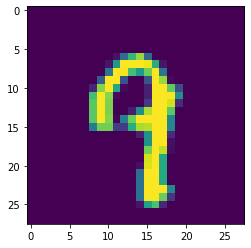

In [17]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
idx = 0
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

In [18]:
model.fit(pdata, plabels, nb_epochs=10)

Epoch 1/10
58/58 [==============================] - 10s 180ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.7515 - acc: 0.75124s - batch: 13.5000 - size: 128.00
Epoch 2/10
58/58 [==============================] - 9s 161ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.2465 - acc: 0.9281
Epoch 3/10
58/58 [==============================] - 9s 161ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.1524 - acc: 0.9561
Epoch 4/10
58/58 [==============================] - 11s 182ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.1123 - acc: 0.9651
Epoch 5/10
58/58 [==============================] - 10s 179ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.0920 - acc: 0.9713
Epoch 6/10
58/58 [==============================] - 10s 179ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.0816 - acc: 0.9758
Epoch 7/10
58/58 [==============================] - 11s 184ms/step - batch: 28.5000 - size: 128.0000 - loss: 0.0642 - acc: 0.97955s - batch: 12.0000 - size: 128
Epoch 8/10
58/58 [=========


Clean test set accuracy: 97.90%


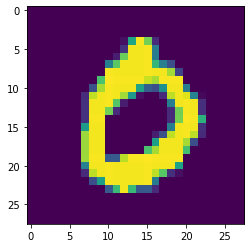

Prediction: 0


In [19]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Poison test set accuracy: 11.79%


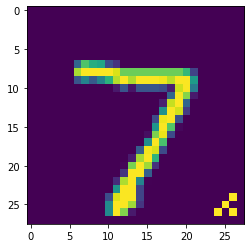

Prediction: 9


In [24]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
#poison_correct = np.sum(poison_preds == np.argmax(py_test, axis=1))
#poison_total = py_test.shape[0]

clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy: %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))